In [1]:
import pandas as pd
from fsrs_optimizer import Optimizer

optimizer = Optimizer()

filename = "../fsrs-optimizer/dataset/collection-2022-09-18@13-21-58.colpkg"

optimizer.anki_extract(filename=filename)

Deck file extracted successfully!
revlog.csv saved.


In [2]:
from itertools import accumulate


df = pd.read_csv("./revlog.csv")
df["delta_t"] = df["review_time"].diff().fillna(0).astype(int) // 1000
df["i"] = df.groupby("card_id").cumcount() + 1
df.loc[df["i"] == 1, "delta_t"] = 0


def cum_concat(x):
    return list(accumulate(x))


t_history = df.groupby("card_id", group_keys=False)["delta_t"].apply(
    lambda x: cum_concat([[int(i)] for i in x])
)
df["t_history"] = [
    ",".join(map(str, item[:-1])) for sublist in t_history for item in sublist
]
r_history = df.groupby("card_id", group_keys=False)["review_rating"].apply(
    lambda x: cum_concat([[i] for i in x])
)
df["r_history"] = [
    ",".join(map(str, item[:-1])) for sublist in r_history for item in sublist
]
df = df[df["delta_t"] > 0]
df[df["r_history"].str.startswith("1") & (df["i"] <= 4)].head(10)
# df[df["review_state"] == Relearning]['r_history'].value_counts()

,review_time,card_id,review_rating,review_duration,review_state,delta_t,i,t_history,r_history
189,1529297007025,1529135687135,3,4149,1,2234,2,0,1
190,1529300482562,1529135687135,4,3107,1,3475,3,"0,2234","1,3"
191,1529590512002,1529135687135,3,5246,2,290029,4,"0,2234,3475","1,3,4"
246,1529300587754,1529136001709,3,1648,1,1,2,0,1
247,1529302537591,1529136001709,3,4320,1,1949,3,"0,1","1,3"
248,1529396203418,1529136001709,3,3816,2,93665,4,"0,1,1949","1,3,3"
290,1529297026422,1529136191208,3,2768,1,2209,2,0,1
291,1529300492324,1529136191208,4,2578,1,3465,3,"0,2209","1,3"
292,1529808150257,1529136191208,3,2806,2,507657,4,"0,2209,3465","1,3,4"
316,1529294818999,1529136831498,3,2233,1,74,2,0,1


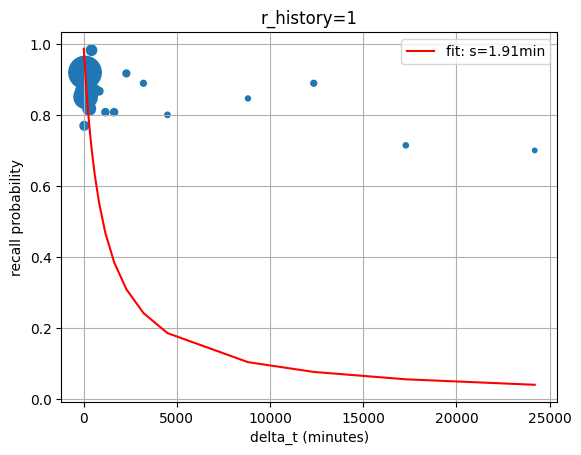

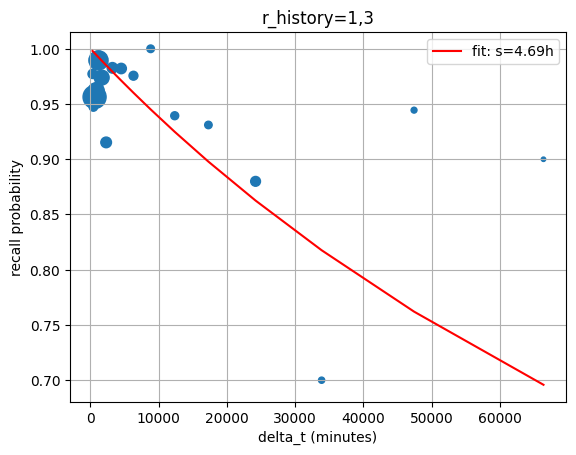

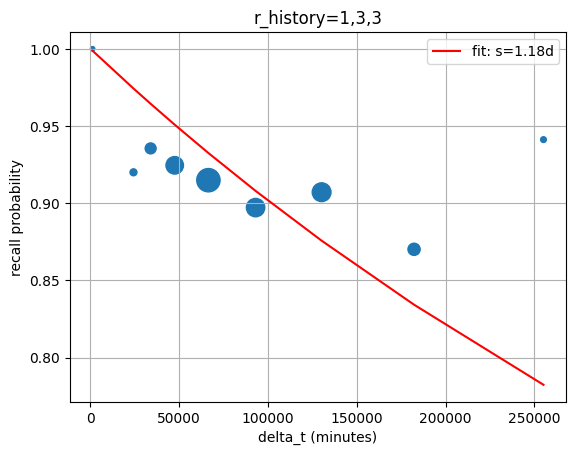

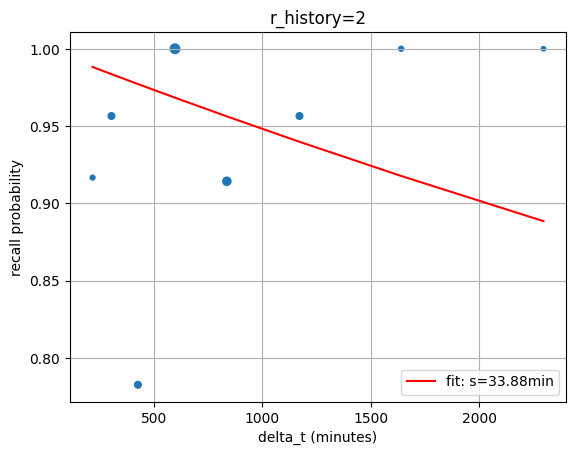

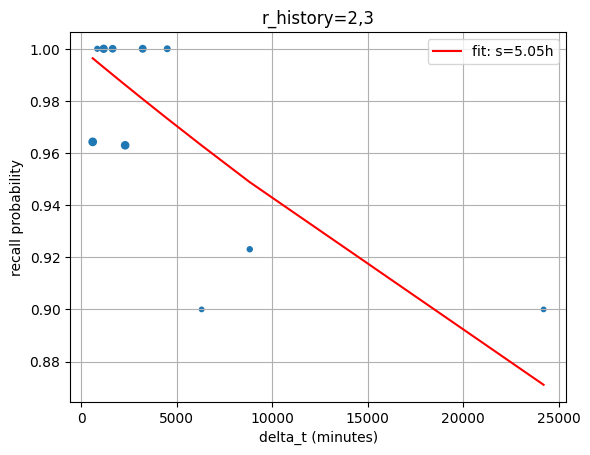

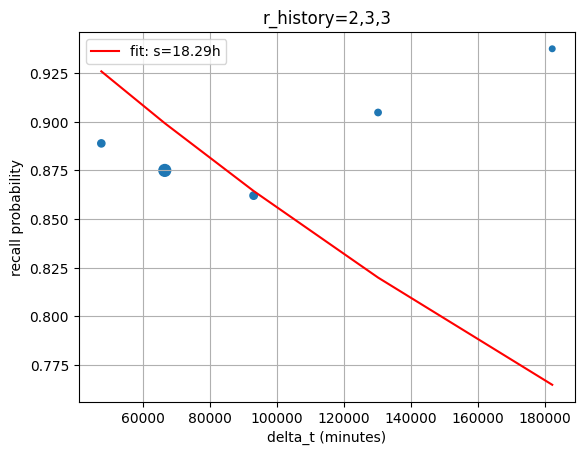

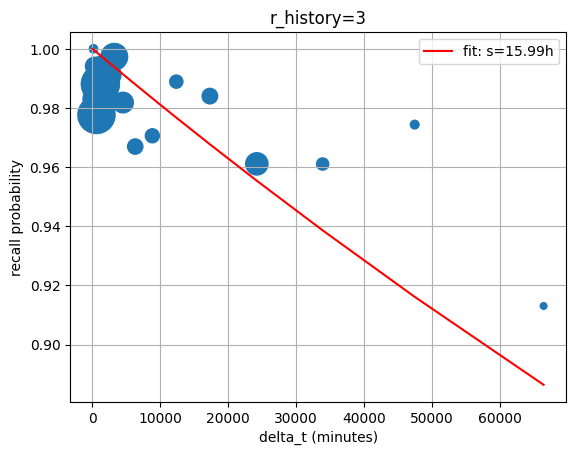

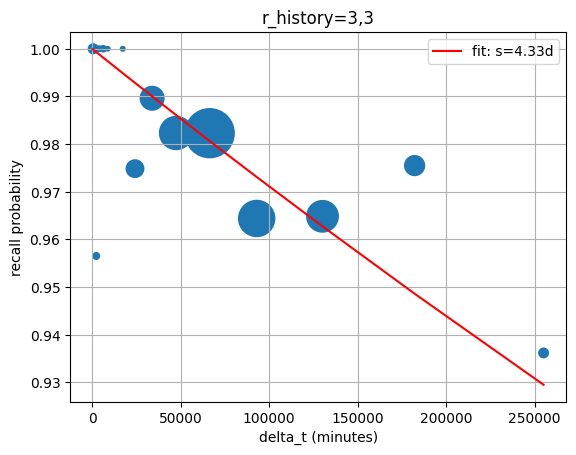

In [3]:
import math
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt


def power_forgetting_curve(t, s):
    return (1 + t / (9 * s)) ** -1


for r_history in ("1", "1,3", "1,3,3", "2", "2,3", "2,3,3", "3", "3,3"):
    df["t_bin"] = df["delta_t"].map(lambda x: round(
        math.pow(1.4, math.floor(math.log(x, 1.4))), 2) if x > 0 else 0)
    df["y"] = df["review_rating"].map(lambda x: 1 if x > 1 else 0)
    tmp = df[df["r_history"] == r_history].groupby("t_bin").agg(
        {"y": ["mean", "count"]}).reset_index().copy()
    tmp = tmp[tmp["y"]["count"] >= 10]
    if tmp.empty:
        continue
    plt.scatter(tmp["t_bin"], tmp[("y", "mean")], s=tmp[("y", "count")])
    popt, pcov = curve_fit(power_forgetting_curve, tmp["t_bin"], tmp[(
        "y", "mean")], sigma=1/tmp[("y", "count")])
    stability = f"{popt[0]:.2f}s" if popt[0] < 60 else f"{popt[0]/60:.2f}min" if popt[0] < 3600 else f"{popt[0]/3600:.2f}h" if popt[0] < 86400 else f"{popt[0]/86400:.2f}d"
    plt.plot(tmp["t_bin"], power_forgetting_curve(
        tmp["t_bin"], *popt), 'r-', label=f'fit: s={stability}')
    plt.title(f"r_history={r_history}")
    plt.xlabel("delta_t (minutes)")
    plt.ylabel("recall probability")
    plt.legend()
    plt.grid()
    plt.show()